In [2]:
%matplotlib inline

# Basic
import io
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices

# SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# NLTK
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [3]:
data = pd.read_csv("training-data/spamcollectiondata.tsv", sep='\t', names = ["Category", "Message"])

In [4]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Comparing freq of capital letters

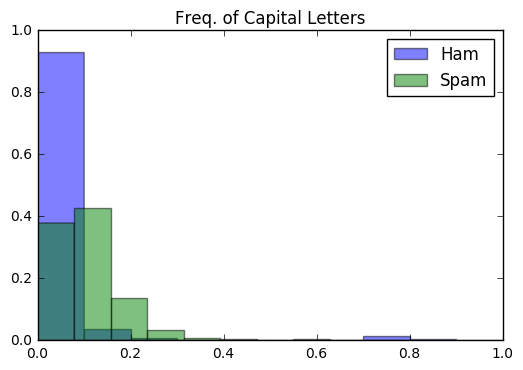

In [18]:
ham_caps = []
spam_caps = []

for index,row in data.iterrows():
    if row.Category == 'ham':
        ham_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))
    else:
        spam_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))

        
ham_weight = np.ones_like(ham_caps)/len(ham_caps)
spam_weight = np.ones_like(spam_caps)/len(spam_caps)

fig, ax = plt.subplots()
ax.hist(ham_caps,weights=ham_weight,color='b',alpha=0.5,label='Ham')
ax.hist(spam_caps,weights=spam_weight,color='g',alpha=0.5,label='Spam')
ax.set(title='Freq. of Capital Letters')
plt.legend()
plt.show()    

### Comparing freq of numbers

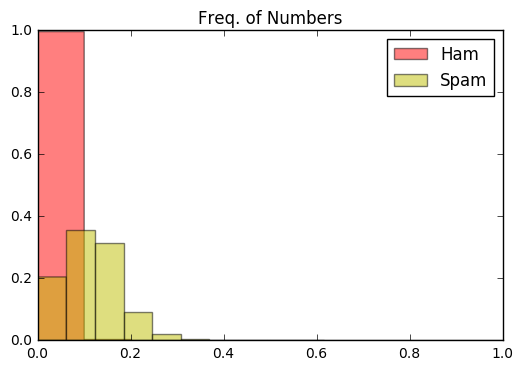

In [19]:
ham_nums = []
spam_nums = []

for index,row in data.iterrows():
    if row.Category == 'ham':
        ham_nums.append(sum(1.0 for c in row.Message if c.isdigit())/sum(1.0 for c in row.Message))
    else:
        spam_nums.append(sum(1.0 for c in row.Message if c.isdigit())/sum(1.0 for c in row.Message))

        
ham_weight = np.ones_like(ham_nums)/len(ham_nums)
spam_weight = np.ones_like(spam_nums)/len(spam_nums)

fig, ax = plt.subplots()
ax.hist(ham_nums,weights=ham_weight,color='r',alpha=0.5,label='Ham')
ax.hist(spam_nums,weights=spam_weight,color='y',alpha=0.5,label='Spam')
ax.set(title='Freq. of Numbers')
plt.legend()
plt.show() 

In [24]:
message_data = [word.lower() for word in data['Message']]
category = data['Category'].tolist()
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
training_set = []
i = 0
for message in message_data:
    sentence = message.split(" ")
    filtered = []
    pr = []
    for word in sentence:
        if word.lower() not in stop:
            stemmed = stemmer.stem(word)
            filtered.append(stemmed)
    pr.append(filtered)
    pr.append(category[i])
    training_set.append(pr)
    i = i+1
    
train_df = pd.DataFrame(training_set)
train_df.columns = ['Lists','Labels']
train_df.head()
y = np.array(train_df.Labels)

for i in range(len(y)):
    if y[i] == 'ham':
        y[i] = 1
    else:
        y[i] = 0
        
y = np.ravel(y)

In [25]:
def list_to_dict(words_list):
  return dict([(word, True) for word in words_list])
 
training_set_formatted = [(list_to_dict(element[0]), element[1]) for element in training_set]

def generate_words_vector(training_set):
    words_vector = [] 
    for review in training_set:
        for word in review[0]:
            if word not in words_vector: words_vector.append(word) 
    return words_vector

def generate_X_matrix(training_set, words_vector):
    no_reviews = len(training_set)
    no_words = len(words_vector)
    X = np.zeros(shape=(no_reviews, no_words+1))
    for ii in range(0,no_reviews):
        X[ii][0] = 1
        review_text = training_set[ii][0]
        total_words_in_review = len(review_text)
        rt = list(review_text)
        for word in rt:
            word_occurences = rt.count(word)
            word_index = words_vector.index(word)+1
            X[ii][word_index] = word_occurences / float(total_words_in_review)
    return X

words_vector = generate_words_vector(training_set_formatted)
X = np.array(generate_X_matrix(training_set_formatted, words_vector))

In [8]:
# What percentage is ham?
print(y.mean())

0.8659368269921034


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df.Labels, test_size=0.5, random_state=1)
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
probs = model.predict_proba(X_test)

predicted = model.predict(X_test)

act = 1 - y[:len(predicted)]
pred = []

for result in predicted:
    if result == 'spam':
        pred.append(1)
    else:
        pred.append(0)
        
# 1 is spam, 0 is ham
compare = pd.DataFrame({'Actual':act,'Predicted':pred,
                       'Prob is Ham':probs[:,0],
                       'Prob is Spam':probs[:,1]})

print(compare[compare['Prob is Spam']>=0.5].head(),'\n')
print(compare.head())

compare.to_csv('log_reg_output.csv',sep=',')

     Actual  Predicted  Prob is Ham  Prob is Spam
2434      0          1     0.464386      0.535614 

  Actual  Predicted  Prob is Ham  Prob is Spam
0      0          0     0.865463      0.134537
1      0          0     0.898919      0.101081
2      1          0     0.860582      0.139418
3      0          0     0.859309      0.140691
4      0          0     0.876628      0.123372


In [12]:
print(metrics.accuracy_score(y_test,predicted))

0.862167982771


In [18]:
print(metrics.confusion_matrix(y_test,predicted))
print(metrics.classification_report(y_test,predicted))

[[2402    1]
 [ 383    0]]
             precision    recall  f1-score   support

        ham       0.86      1.00      0.93      2403
       spam       0.00      0.00      0.00       383

avg / total       0.74      0.86      0.80      2786



In [13]:
print(pd.DataFrame(y_test).describe())

       Labels
count    1672
unique      2
top       ham
freq     1451


In [14]:
# Comparing Ratio of Spam/Ham to Model's Ratio of 
print(1451.0/1672,1669.0/1672)

0.867822966507177 0.9982057416267942


In [32]:
print(data[data.Category=='spam'].Message.head())

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: Message, dtype: object


### Testing Our Model

In [ ]:
test_phrase_1 = "lt gt go come ok love"
test_phrase_2 = "call free mobil co.uk"

In [91]:
arr_1 = np.zeros(len(X[0]))
arr_2 = np.zeros(len(X[0]))

for ii in range(len(test_phrase_1.split())):
    review_text = test_phrase_1.split()
    total_words_in_review = len(review_text)
    rt = list(review_text)
    for word in rt:
        word_occurences = rt.count(word)
        if word in words_vector:
            word_index = words_vector.index(word)+1
            arr_1[word_index] = word_occurences / float(total_words_in_review)

for ii in range(len(test_phrase_2.split())):
    review_text = test_phrase_2.split()
    total_words_in_review = len(review_text)
    rt = list(review_text)
    for word in rt:
        word_occurences = rt.count(word)
        if word in words_vector:
            word_index = words_vector.index(word)+1
            arr_2[word_index] = word_occurences / float(total_words_in_review)
            
arr_1[0] = 1
arr_2[0] = 1

pct_1 = model.predict_proba(arr_1.reshape(1,-1))[0][0]*100
pct_2 = model.predict_proba(arr_2.reshape(1,-1))[0][0]*100

###########################

result_1 = result_2 = 'SPAM'

if(pct_1>50):
    result_1 = 'HAM'
if(pct_2>50):
    result_2 = 'HAM'    

In [92]:
print("\"{}\" --> {} \n\t{}% Ham / {}% Spam.".format(test_phrase_1,result_1,round(pct_1,1),round(100-pct_1,1)),"\n")
print("\"{}\" --> {} \n\t{}% Ham / {}% Spam.".format(test_phrase_2,result_2,round(pct_2,1),round(100-pct_2,1)))

"call free mobil co.uk" --> SPAM 
	45.6% Ham / 54.4% Spam. 

"Hi Hows it going!" --> HAM 
	87.4% Ham / 12.6% Spam.
